作者: 阿凯爱玩机器人 | 微信: xingshunkai  | QQ: 244561792

[B站](https://space.bilibili.com/40344504) | [淘宝店铺](https://shop140985627.taobao.com) | [购买链接](https://item.taobao.com/item.htm?id=677075846402)

## 导入依赖

In [1]:
import numpy as np
import cv2
import open3d as o3d
import mediapipe as mp
from matplotlib import pyplot as plt
# 阿凯机器人工具箱
from kyle_robot_toolbox.camera import Gemini335
from kyle_robot_toolbox.open3d import *
# 自定义库
# - 手掌可视化库
from hand_o3d_gui import get_hand_geomery

%matplotlib inline

pybullet build time: Jun  3 2022 02:05:55


## 相机初始化

In [2]:
# 创建相机对象
camera = Gemini335()

astra配置文件夹路径: ../astra-config/config/
初始化视频流:  color
UVC 相机设备号: 0
检测到产品型号为: Astra Pro
初始化UVC视频流


## 创建手掌关键点检测

In [3]:
# min_detection_confidence: 置信度阈值 
# min_tracking_confidence: 跟踪阈值
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    model_complexity=0,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## 采集图像

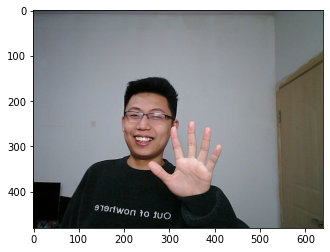

In [225]:
# 采集图像
# 注: 前几帧图像质量不好，可以多采集几次  
# 另外确保画面中有手
img_bgr = camera.read_color_img()
# 为了获取正确的左右手判断，将图像镜像
img_bgr = cv2.flip(img_bgr, 1)

# 图像可视化
plt.imshow(img_bgr[:, :, ::-1])

In [1]:
# img_bgr = cv2.imread("damei.png")
# plt.imshow(img_bgr[:, :, ::-1])

In [5]:
# cv2.imwrite("hand_image_raw.png", img_bgr)

## 手掌关键点检测

In [262]:
# 为了提高性能， 将图像标记为只读模式
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_rgb.flags.writeable = False
# 手掌关键点检测
results = hands.process(img_rgb)

### multi_hand_landmarks    

In [263]:
# 获取图像中的2D关键点
# x,y: 关键点在2D图像上的像素坐标(百分比形式)
# z: z为相对与手掌根处的像素距离(百分比形式)
pixel_landmark = results.multi_hand_landmarks[0].landmark
print(f"关键点个数: {len(pixel_landmark)}")
print(pixel_landmark)

关键点个数: 21
[x: 0.35126200318336487
y: 0.8873727917671204
z: 1.2460700027361327e-08
, x: 0.3891764283180237
y: 0.8397866487503052
z: -0.01257161982357502
, x: 0.41273850202560425
y: 0.7785155177116394
z: -0.023951485753059387
, x: 0.4328208565711975
y: 0.7321752905845642
z: -0.03768755495548248
, x: 0.45362135767936707
y: 0.7052913308143616
z: -0.052663300186395645
, x: 0.3598915934562683
y: 0.71087247133255
z: -0.008716782554984093
, x: 0.36200106143951416
y: 0.6432908177375793
z: -0.020470507442951202
, x: 0.36135971546173096
y: 0.6060410737991333
z: -0.03014233708381653
, x: 0.35840681195259094
y: 0.5731898546218872
z: -0.03785785287618637
, x: 0.33082765340805054
y: 0.7146977782249451
z: -0.016723431646823883
, x: 0.313394159078598
y: 0.6453191041946411
z: -0.024330556392669678
, x: 0.3027206063270569
y: 0.6051722764968872
z: -0.03458862006664276
, x: 0.2910514771938324
y: 0.5708451271057129
z: -0.04479803144931793
, x: 0.30789124965667725
y: 0.7339851260185242
z: -0.0274826623499393

In [264]:
# 获取Landmark的像素坐标
# 获取第一个关键点的像素坐标
mark_idx = 0
px = int(pixel_landmark[mark_idx].x * camera.img_width)
py = int(pixel_landmark[mark_idx].y * camera.img_height)

print(f"关键点:{mark_idx} 像素坐标: px={px} py={py}")

关键点:0 像素坐标: px=224 py=425


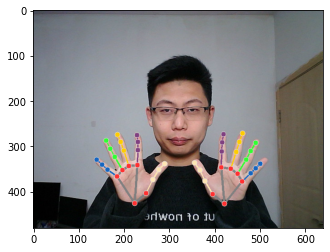

In [265]:
# 绘制手指关键点
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

canvas = np.copy(img_bgr)
for hand_landmarks in results.multi_hand_landmarks:
    mp_drawing.draw_landmarks(
        canvas,
        hand_landmarks,
        mp_hands.HAND_CONNECTIONS,
        mp_drawing_styles.get_default_hand_landmarks_style(),
        mp_drawing_styles.get_default_hand_connections_style())
plt.imshow(canvas[:, :, ::-1])

In [266]:
# cv2.imwrite("canvas1.png", canvas)

True

关键点序号可视化

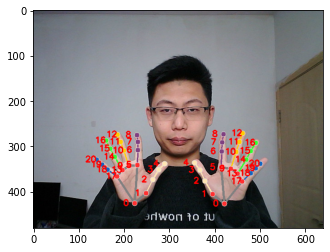

In [267]:
for hand_landmarks in results.multi_hand_landmarks:    
    for i, mark in enumerate(hand_landmarks.landmark):
        px = int(mark.x * camera.img_width)
        py = int(mark.y * camera.img_height)
        cv2.putText(canvas, str(i), (px-25, py+5), \
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
plt.imshow(canvas[:, :, ::-1])

In [268]:
# cv2.imwrite("canvas2.png", canvas)

True

In [11]:
# cv2.imwrite("hand_landmark.png", canvas)

### multi_hand_world_landmarks


In [273]:
# 获取关键点在手掌等效中心坐标系下的三维坐标 [x, y, z]
# 单位m
world_landmark = results.multi_hand_world_landmarks[0].landmark

print(world_landmark)

[x: 0.014369534328579903
y: 0.08078421652317047
z: 0.01250328030437231
, x: 0.03682761266827583
y: 0.05194723233580589
z: 0.005294020753353834
, x: 0.05418867990374565
y: 0.03138704597949982
z: -0.003323222976177931
, x: 0.06918952614068985
y: 0.0077799297869205475
z: -0.011962365359067917
, x: 0.07707522064447403
y: -0.01053519919514656
z: -0.015183860436081886
, x: 0.022925715893507004
y: -0.008313422091305256
z: 0.0028083331417292356
, x: 0.022333255037665367
y: -0.03367113694548607
z: -0.0021245745010674
, x: 0.021434295922517776
y: -0.04933043196797371
z: -0.013618228957057
, x: 0.022662103176116943
y: -0.06340766698122025
z: -0.03873230889439583
, x: 0.0026634889654815197
y: -0.005866821389645338
z: 0.0021308548748493195
, x: -0.00626223161816597
y: -0.03249027952551842
z: -0.00041910167783498764
, x: -0.010468600317835808
y: -0.05274351313710213
z: -0.01396528072655201
, x: -0.014519501477479935
y: -0.06912685930728912
z: -0.03965814411640167
, x: -0.015265412628650665
y: 0.0043

In [270]:
# 获取Landmark的像素坐标
# 获取第一个关键点的像素坐标
mark_idx = 0
wx = world_landmark[mark_idx].x
wy = world_landmark[mark_idx].y
wz = world_landmark[mark_idx].z

print(f"关键点:{mark_idx} 三维坐标: wx={wx:.3f} wy={wy:.3f} wz={wy:.3f} m")


关键点:0 三维坐标: wx=0.014 wy=0.081 wz=0.081 m


In [271]:
# 获取三维点集
point3d_list = []
for pidx, point in enumerate(world_landmark):
    # 追加3D列表
    point3d_list.append([point.x, point.y, point.z])
# 关键点类型转换
point3d_list = np.float64(point3d_list)

## 手掌关键点三维可视化(Open3D)
在Open3D中绘制一下21个关键点
![](./image/手掌三维姿态.png)

In [272]:
geomery_list = get_hand_geomery(point3d_list)
draw_geometry(geomery_list, bk_color=[0.8, 0.8, 0.8])

## multi_handedness

In [274]:
# 手掌的基本属性
# - index: 类别ID 左手 0,右手 1
# - score: 置信度
# - label: 标签名称 左手 "Left", 右手"Right"
print(results.multi_handedness)

[classification {
  index: 0
  score: 0.9051958322525024
  label: "Left"
}
, classification {
  index: 1
  score: 0.7418656945228577
  label: "Right"
}
]
